In [113]:
from sklearn.model_selection import train_test_split
import numpy as np
import skfda

X = np.load('X.npy')
y = np.load('y.npy')

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X/15, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

X_train = skfda.FDataGrid(X_train, grid_points=np.linspace(0, 1, 150))
X_val = skfda.FDataGrid(X_val, grid_points=np.linspace(0, 1, 150))
X_test = skfda.FDataGrid(X_test, grid_points=np.linspace(0, 1, 150))


In [114]:
y_test.sum()

np.int64(1145)

In [115]:
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
from skfda.preprocessing.smoothing.validation import  LinearSmootherGeneralizedCVScorer
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother


    
bandwidth = np.linspace(0.01, 1, 150)


# Nadaraya-Watson kernel smoother
nw = SmoothingParameterSearch(
    KernelSmoother(kernel_estimator=NadarayaWatsonHatMatrix()),
    bandwidth,
    scoring=LinearSmootherGeneralizedCVScorer(penalization_function=lambda t:1),
    param_name='kernel_estimator__bandwidth'
)

nw.fit(X_train)
X_train_smooth = nw.transform(X_train)
X_val_smooth = nw.transform(X_val)
X_test_smooth = nw.transform(X_test)


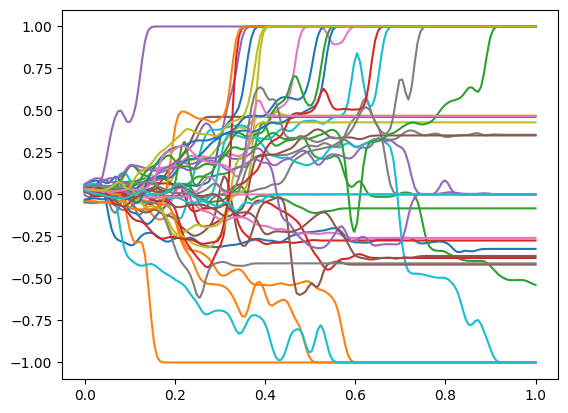

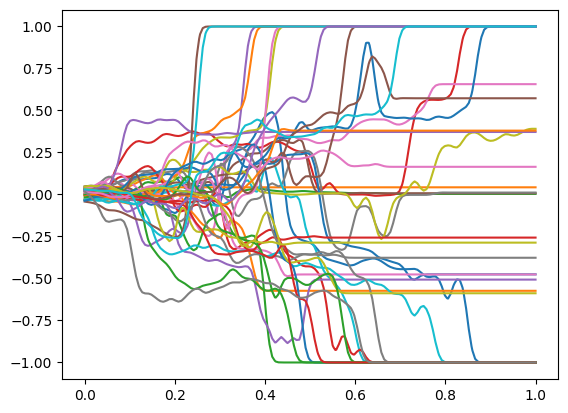

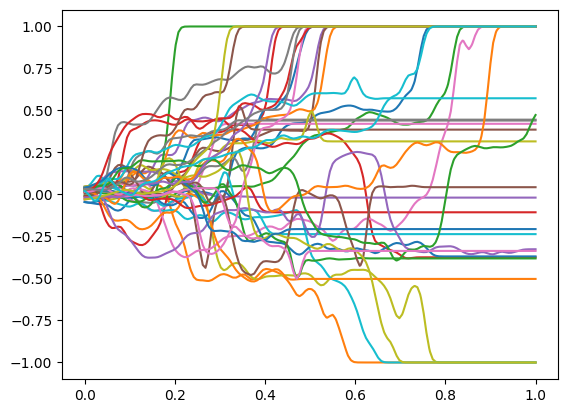

In [116]:
import matplotlib.pyplot as plt
X_val_smooth[:40].plot()
X_test_smooth[:40].plot()
X_train_smooth[:40].plot()
plt.show()

In [65]:
import skfda.ml.classification as sc
from sklearn.metrics import classification_report

neigh = sc.KNeighborsClassifier()
neigh.fit(X_train_smooth, y_train)
y_pred_knn = neigh.predict(X_test_smooth)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

       False       0.77      0.71      0.74      1531
        True       0.65      0.71      0.68      1145

    accuracy                           0.71      2676
   macro avg       0.71      0.71      0.71      2676
weighted avg       0.72      0.71      0.71      2676



In [66]:
neigh = sc.NearestCentroid()
neigh.fit(X_train_smooth, y_train)
y_pred_knn = neigh.predict(X_test_smooth)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

       False       0.80      0.60      0.69      1531
        True       0.60      0.80      0.69      1145

    accuracy                           0.69      2676
   macro avg       0.70      0.70      0.69      2676
weighted avg       0.72      0.69      0.69      2676



In [67]:
neigh = sc.MaximumDepthClassifier()
neigh.fit(X_train_smooth, y_train)
y_pred_knn = neigh.predict(X_test_smooth)
print(classification_report(y_test, y_pred_knn))

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\skfda\preprocessing\feature_construction\_per_class_transformer.py:212: UserWarning: Parameter 'transformer' with type <class 'skfda.exploratory.depth._depth.ModifiedBandDepth'> should use the data for  fitting.It should have the 'stateless' tag set to 'False'
  warnings.warn(


              precision    recall  f1-score   support

       False       0.77      0.67      0.72      1531
        True       0.63      0.74      0.68      1145

    accuracy                           0.70      2676
   macro avg       0.70      0.70      0.70      2676
weighted avg       0.71      0.70      0.70      2676



In [68]:
neigh = sc.LogisticRegression(max_features=10)
neigh.fit(X_train_smooth, y_train)
y_pred_knn = neigh.predict(X_test_smooth)
print(classification_report(y_test, y_pred_knn))

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

              precision    recall  f1-score   support

       False       0.76      0.87      0.81      1531
        True       0.78      0.64      0.70      1145

    accuracy                           0.77      2676
   macro avg       0.77      0.75      0.76      2676
weighted avg       0.77      0.77      0.77      2676



In [69]:
import tensorflow as tf

In [78]:
from skfda.preprocessing.dim_reduction import FPCA
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
n = 20
pca = FPCA(n_components=n)
X_train_pca = pca.fit_transform(X_train_smooth)
X_test_pca = pca.transform(X_test_smooth)
X_val_pca = pca.transform(X_val_smooth)

# Define the neural network model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(n,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pca, y_train, epochs=50, batch_size=32, validation_data=(X_val_pca, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pca, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6846 - loss: 0.6174 - val_accuracy: 0.7216 - val_loss: 0.5581
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7134 - loss: 0.5647 - val_accuracy: 0.7309 - val_loss: 0.5429
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7326 - loss: 0.5547 - val_accuracy: 0.7433 - val_loss: 0.5362
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7287 - loss: 0.5523 - val_accuracy: 0.7399 - val_loss: 0.5376
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7359 - loss: 0.5444 - val_accuracy: 0.7481 - val_loss: 0.5295
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7343 - loss: 0.5444 - val_accuracy: 0.7474 - val_loss: 0.5262
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7379 - loss: 0.5352 - val_accuracy: 0.7522 - val_loss: 0.5259
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7432 - loss: 0.5277 - val_accuracy: 0.7522 - val_

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


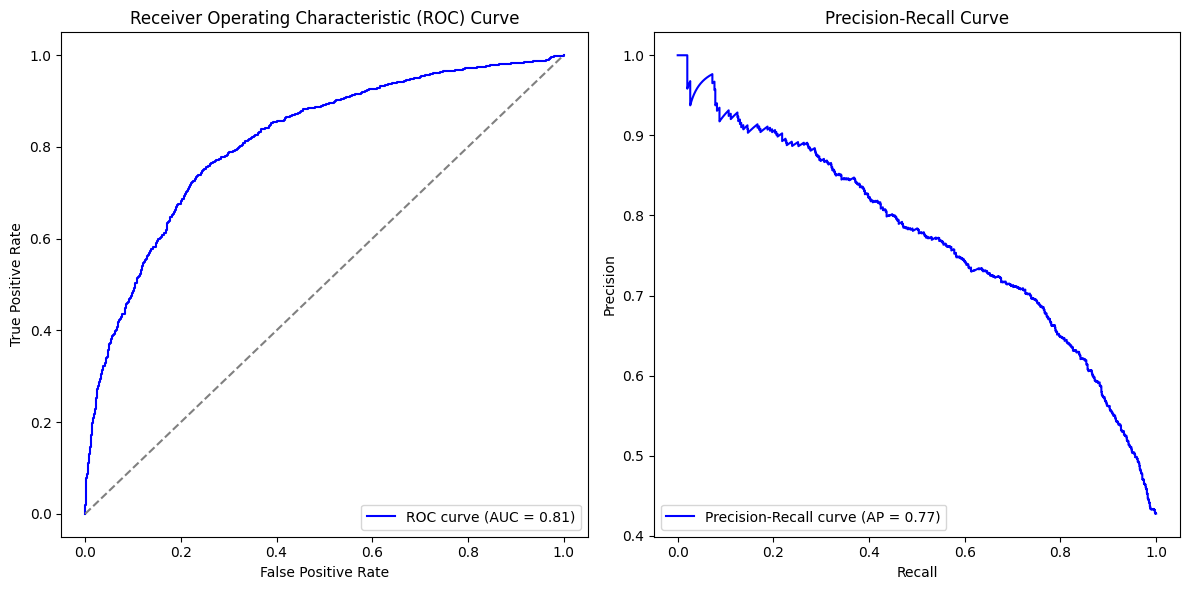

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

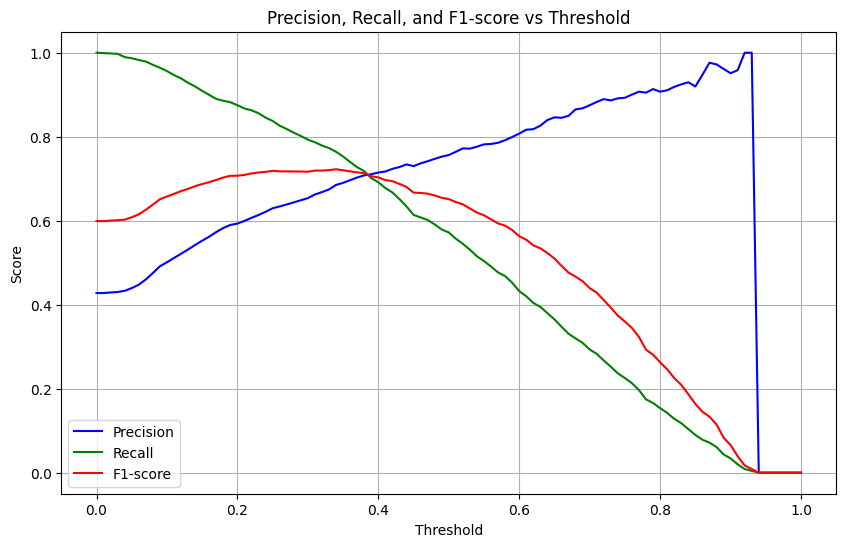

In [79]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_pca)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [273]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
n = 30
pca = FPCA(n_components=n)
X_train_pca = pca.fit_transform(X_train_smooth)
X_test_pca = pca.transform(X_test_smooth)
X_val_pca = pca.transform(X_val_smooth)

# 1. Instantiate the classifier with some reasonable defaults
xgb_clf = xgb.XGBClassifier(
   # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss' # or 'auc'
)

# 2. Fit with early stopping on the validation set
xgb_clf.fit(
    X_train_pca, y_train,
    eval_set=[(X_val_pca, y_val)],
    verbose=True
)

# 3. Predictions on test set
y_pred = xgb_clf.predict(X_test_pca)
y_prob = xgb_clf.predict_proba(X_test_pca)[:,1]

# 4. Evaluation
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

[0]	validation_0-logloss:0.62557
[1]	validation_0-logloss:0.58763
[2]	validation_0-logloss:0.56383
[3]	validation_0-logloss:0.54950
[4]	validation_0-logloss:0.53887
[5]	validation_0-logloss:0.53071
[6]	validation_0-logloss:0.52525
[7]	validation_0-logloss:0.51907
[8]	validation_0-logloss:0.51494
[9]	validation_0-logloss:0.51412
[10]	validation_0-logloss:0.51050
[11]	validation_0-logloss:0.50757
[12]	validation_0-logloss:0.50742
[13]	validation_0-logloss:0.50710
[14]	validation_0-logloss:0.50797
[15]	validation_0-logloss:0.50584
[16]	validation_0-logloss:0.50542
[17]	validation_0-logloss:0.50439
[18]	validation_0-logloss:0.50497
[19]	validation_0-logloss:0.50346
[20]	validation_0-logloss:0.50252
[21]	validation_0-logloss:0.50212
[22]	validation_0-logloss:0.50373
[23]	validation_0-logloss:0.50514
[24]	validation_0-logloss:0.50628


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:30:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[25]	validation_0-logloss:0.50602
[26]	validation_0-logloss:0.50534
[27]	validation_0-logloss:0.50544
[28]	validation_0-logloss:0.50552
[29]	validation_0-logloss:0.50544
[30]	validation_0-logloss:0.50675
[31]	validation_0-logloss:0.50664
[32]	validation_0-logloss:0.50652
[33]	validation_0-logloss:0.50653
[34]	validation_0-logloss:0.50617
[35]	validation_0-logloss:0.50574
[36]	validation_0-logloss:0.50783
[37]	validation_0-logloss:0.50826
[38]	validation_0-logloss:0.50835
[39]	validation_0-logloss:0.50980
[40]	validation_0-logloss:0.50908
[41]	validation_0-logloss:0.50957
[42]	validation_0-logloss:0.50999
[43]	validation_0-logloss:0.51027
[44]	validation_0-logloss:0.50917
[45]	validation_0-logloss:0.50963
[46]	validation_0-logloss:0.51017
[47]	validation_0-logloss:0.51059
[48]	validation_0-logloss:0.51165
[49]	validation_0-logloss:0.51210
[50]	validation_0-logloss:0.51175
[51]	validation_0-logloss:0.51276
[52]	validation_0-logloss:0.51362
[53]	validation_0-logloss:0.51267
[54]	validatio

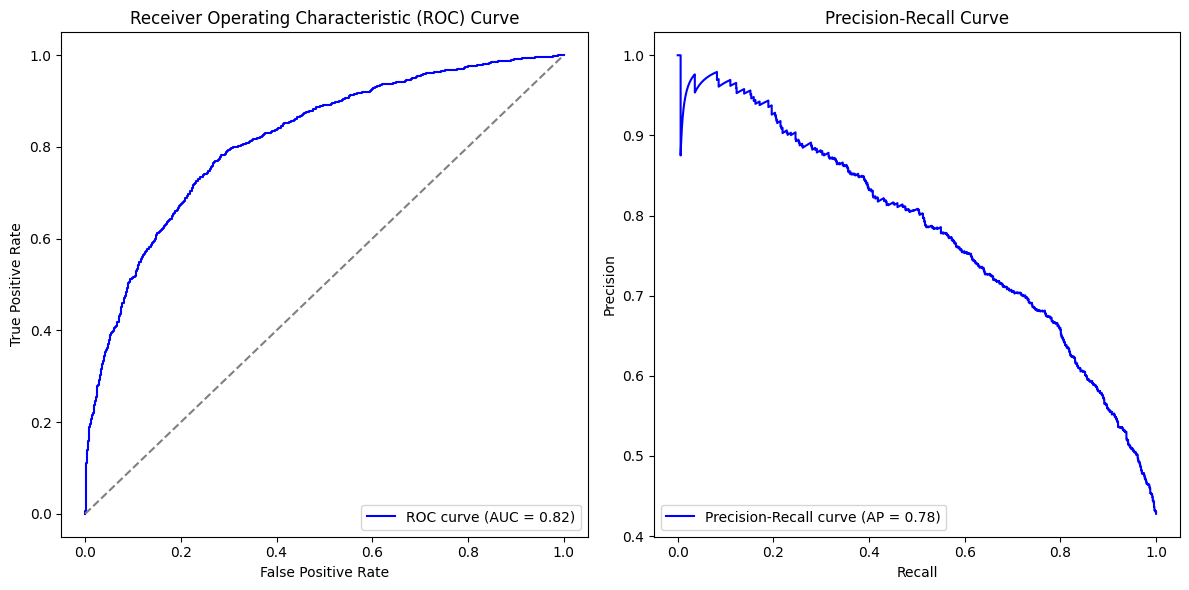

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


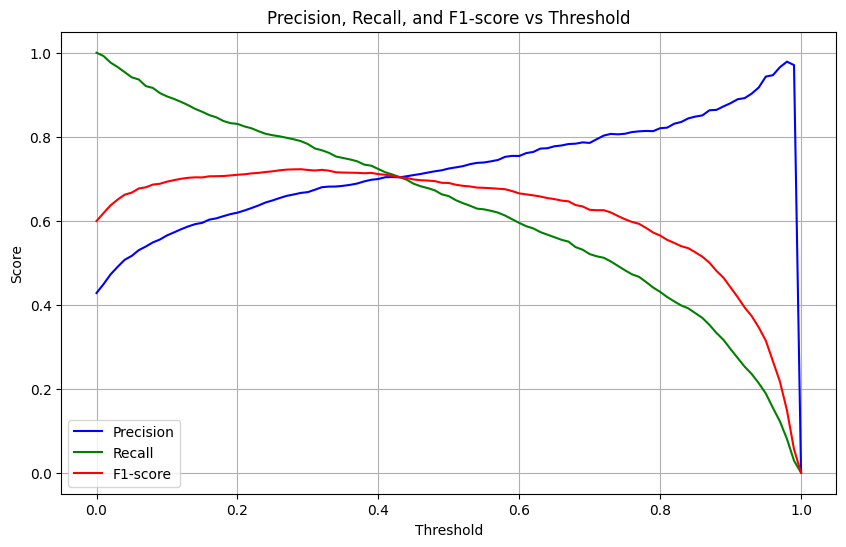

In [275]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob =y_prob

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [73]:
from skfda.preprocessing.dim_reduction import FPLS

pls = FPLS().fit(X_train_smooth, y_train)
X_train_pls = pls.transform(X_train_smooth)
X_test_pls = pls.transform(X_test_smooth)
X_val_pls = pls.transform(X_val_smooth)

# Define the neural network model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_pls.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pls, y_train, epochs=50, batch_size=32, validation_data=(X_val_pls, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pls, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6847 - loss: 0.6208 - val_accuracy: 0.7108 - val_loss: 0.5770
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6906 - loss: 0.5846 - val_accuracy: 0.7108 - val_loss: 0.5764
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6941 - loss: 0.5825 - val_accuracy: 0.7096 - val_loss: 0.5744
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6850 - loss: 0.5897 - val_accuracy: 0.7067 - val_loss: 0.5744
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6974 - loss: 0.5802 - val_accuracy: 0.7108 - val_loss: 0.5731
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6856 - loss: 0.5951 - val_accuracy: 0.7089 - val_loss: 0.5748
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6866 - loss: 0.5873 - val_accuracy: 0.7085 - val_loss: 0.5727
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6840 - loss: 0.5911 - val_accuracy: 0.7104 - val_

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


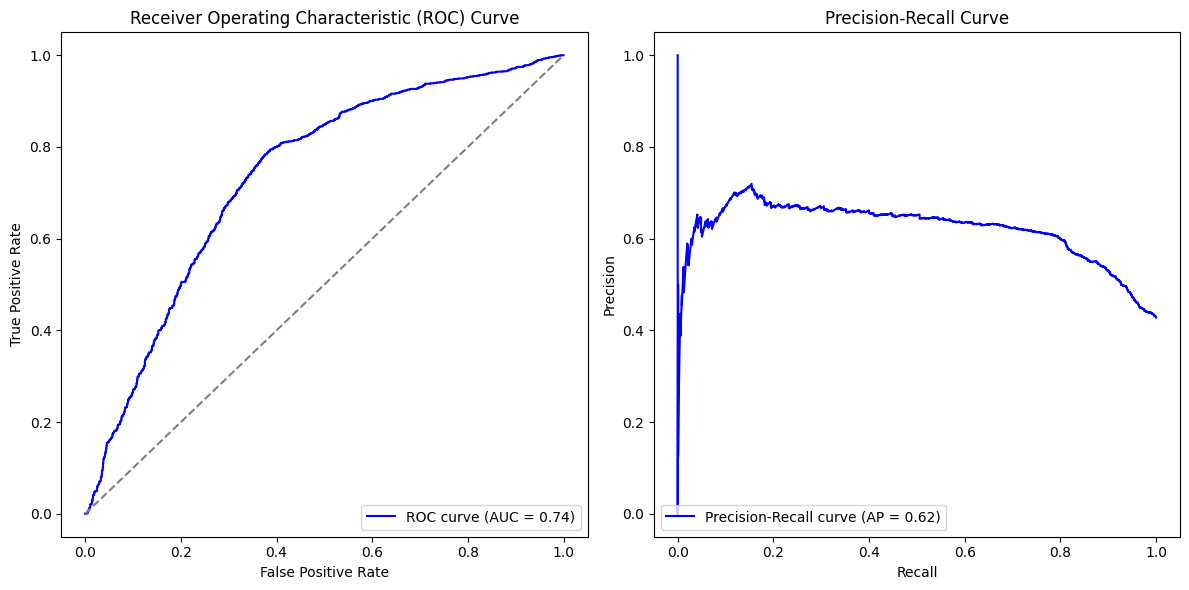

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

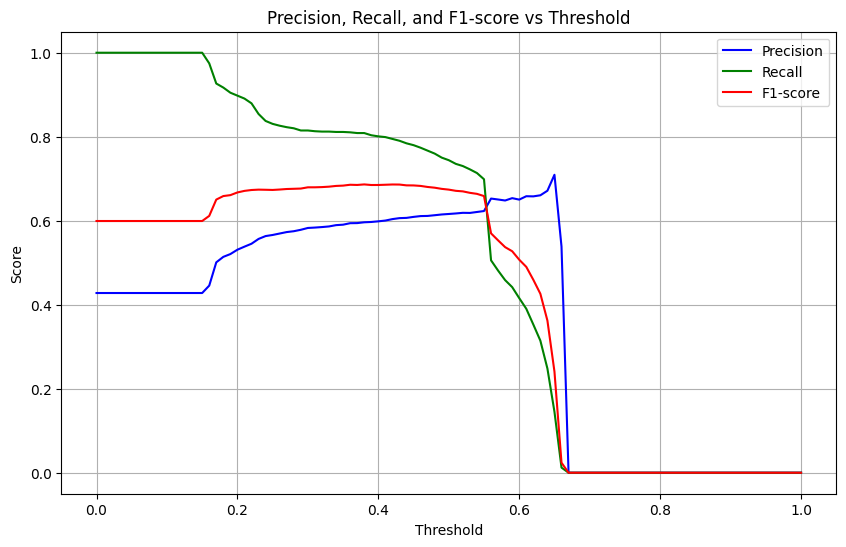

In [75]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_pls)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [228]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. Instantiate the classifier with some reasonable defaults
xgb_clf = xgb.XGBClassifier(
   # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss' # or 'auc'
)

# 2. Fit with early stopping on the validation set
xgb_clf.fit(
    X_train_pls, y_train,
    eval_set=[(X_val_pls, y_val)],
    verbose=True
)

# 3. Predictions on test set
y_pred = xgb_clf.predict(X_test_pls)
y_prob = xgb_clf.predict_proba(X_test_pls)[:,1]

# 4. Evaluation
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

[0]	validation_0-logloss:0.63246
[1]	validation_0-logloss:0.60557
[2]	validation_0-logloss:0.59088
[3]	validation_0-logloss:0.58286
[4]	validation_0-logloss:0.57809
[5]	validation_0-logloss:0.57548
[6]	validation_0-logloss:0.57378
[7]	validation_0-logloss:0.57340
[8]	validation_0-logloss:0.57320
[9]	validation_0-logloss:0.57301
[10]	validation_0-logloss:0.57280
[11]	validation_0-logloss:0.57292
[12]	validation_0-logloss:0.57290
[13]	validation_0-logloss:0.57298
[14]	validation_0-logloss:0.57305
[15]	validation_0-logloss:0.57299
[16]	validation_0-logloss:0.57329
[17]	validation_0-logloss:0.57345
[18]	validation_0-logloss:0.57345
[19]	validation_0-logloss:0.57361
[20]	validation_0-logloss:0.57376
[21]	validation_0-logloss:0.57377
[22]	validation_0-logloss:0.57386
[23]	validation_0-logloss:0.57418
[24]	validation_0-logloss:0.57446
[25]	validation_0-logloss:0.57450
[26]	validation_0-logloss:0.57486
[27]	validation_0-logloss:0.57493
[28]	validation_0-logloss:0.57521
[29]	validation_0-loglos

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:09:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[65]	validation_0-logloss:0.57917
[66]	validation_0-logloss:0.57924
[67]	validation_0-logloss:0.57934
[68]	validation_0-logloss:0.57944
[69]	validation_0-logloss:0.57959
[70]	validation_0-logloss:0.57962
[71]	validation_0-logloss:0.57963
[72]	validation_0-logloss:0.57960
[73]	validation_0-logloss:0.57960
[74]	validation_0-logloss:0.57965
[75]	validation_0-logloss:0.57971
[76]	validation_0-logloss:0.57986
[77]	validation_0-logloss:0.57991
[78]	validation_0-logloss:0.57991
[79]	validation_0-logloss:0.58003
[80]	validation_0-logloss:0.58006
[81]	validation_0-logloss:0.58012
[82]	validation_0-logloss:0.58018
[83]	validation_0-logloss:0.58027
[84]	validation_0-logloss:0.58029
[85]	validation_0-logloss:0.58032
[86]	validation_0-logloss:0.58034
[87]	validation_0-logloss:0.58039
[88]	validation_0-logloss:0.58041
[89]	validation_0-logloss:0.58048
[90]	validation_0-logloss:0.58049
[91]	validation_0-logloss:0.58055
[92]	validation_0-logloss:0.58062
[93]	validation_0-logloss:0.58063
[94]	validatio

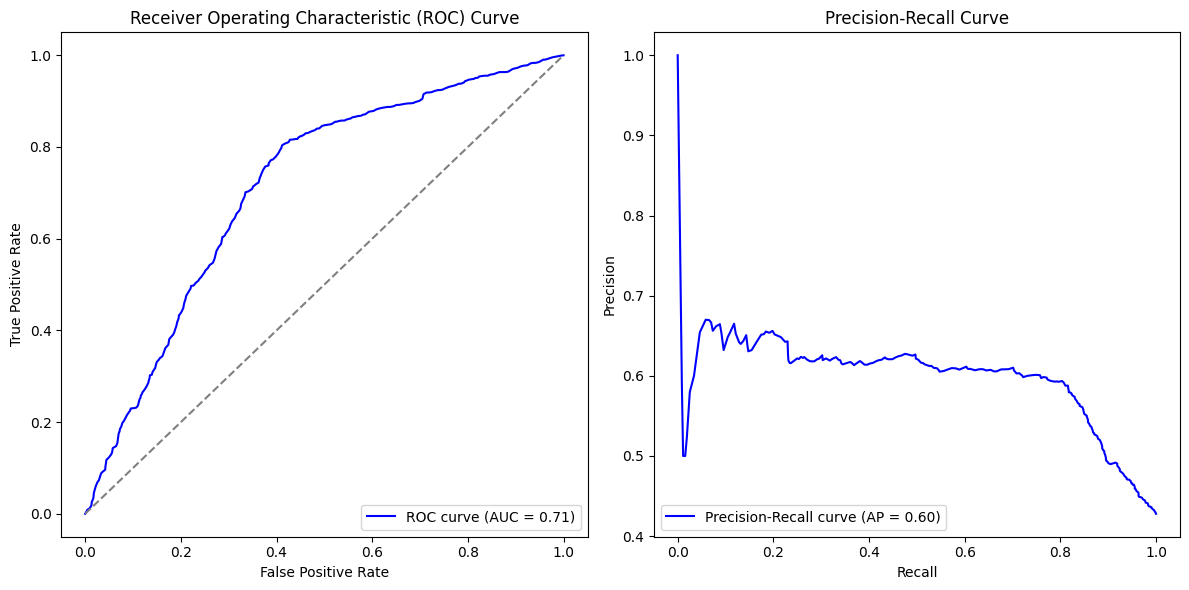

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

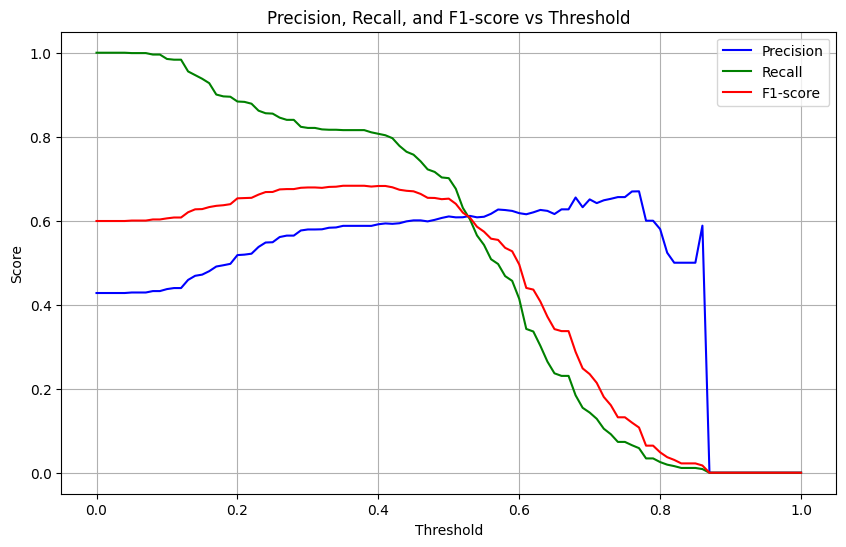

In [229]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = y_prob

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [264]:
X_val_smooth.data_matrix.shape

(2676, 150, 1)

In [268]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. Instantiate the classifier with some reasonable defaults
xgb_clf = xgb.XGBClassifier(
   # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss', # or 'auc'
    n_estimators=200,
    scale_pos_weight= (len(y_train) - y_train.sum()) / y_train.sum(), # class imbalance
)

# 2. Fit with early stopping on the validation set
xgb_clf.fit(
    X_train_smooth.data_matrix[:,:,0], y_train,
    eval_set=[(X_val_smooth.data_matrix[:,:,0], y_val)],
    verbose=True
)

# 3. Predictions on test set
y_pred = xgb_clf.predict(X_test_smooth.data_matrix[:,:,0])
y_prob = xgb_clf.predict_proba(X_test_smooth.data_matrix[:,:,0])[:,1]

# 4. Evaluation
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

[0]	validation_0-logloss:0.57667
[1]	validation_0-logloss:0.51086
[2]	validation_0-logloss:0.46811
[3]	validation_0-logloss:0.44172
[4]	validation_0-logloss:0.42482
[5]	validation_0-logloss:0.41309
[6]	validation_0-logloss:0.40320


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:25:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[7]	validation_0-logloss:0.39688
[8]	validation_0-logloss:0.39413
[9]	validation_0-logloss:0.39052
[10]	validation_0-logloss:0.38467
[11]	validation_0-logloss:0.38189
[12]	validation_0-logloss:0.37986
[13]	validation_0-logloss:0.37781
[14]	validation_0-logloss:0.37597
[15]	validation_0-logloss:0.37447
[16]	validation_0-logloss:0.37197
[17]	validation_0-logloss:0.37067
[18]	validation_0-logloss:0.37003
[19]	validation_0-logloss:0.36976
[20]	validation_0-logloss:0.37053
[21]	validation_0-logloss:0.37051
[22]	validation_0-logloss:0.37047
[23]	validation_0-logloss:0.36976
[24]	validation_0-logloss:0.36851
[25]	validation_0-logloss:0.36875
[26]	validation_0-logloss:0.36806
[27]	validation_0-logloss:0.36582
[28]	validation_0-logloss:0.36404
[29]	validation_0-logloss:0.36534
[30]	validation_0-logloss:0.36430
[31]	validation_0-logloss:0.36226
[32]	validation_0-logloss:0.36163
[33]	validation_0-logloss:0.36157
[34]	validation_0-logloss:0.36032
[35]	validation_0-logloss:0.35999
[36]	validation_0

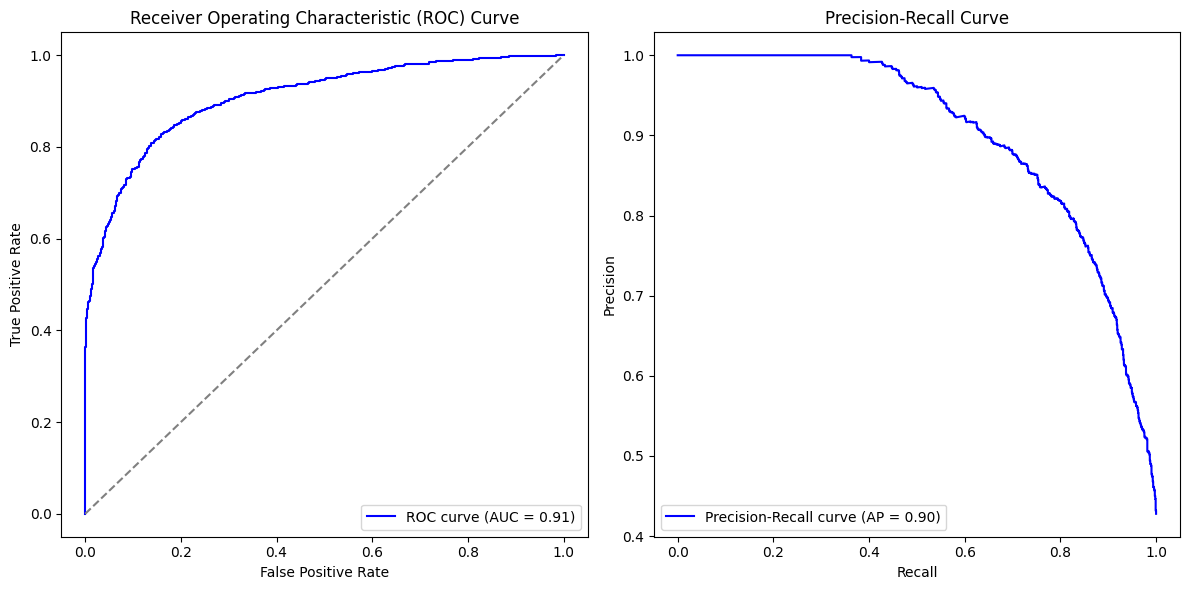

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


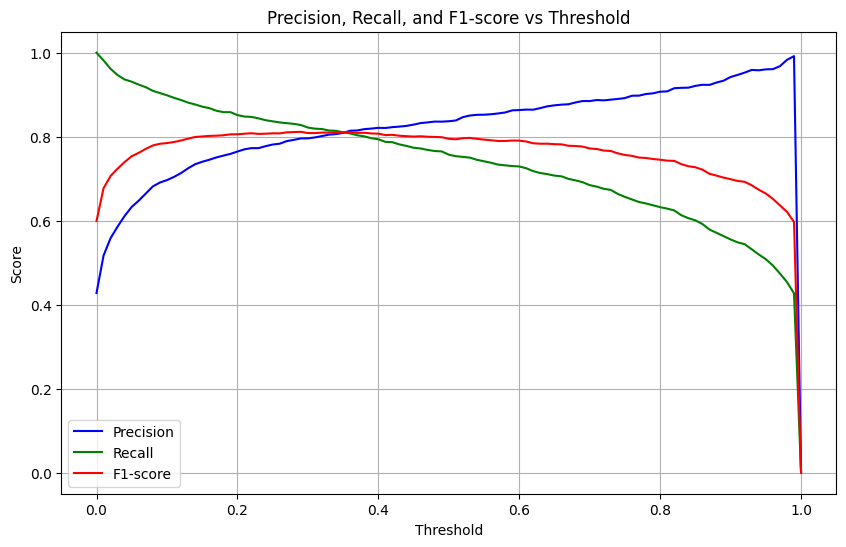

In [269]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = y_prob

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [171]:
from skfda.preprocessing.dim_reduction.variable_selection import RecursiveMaximaHunting

# Apply Recursive Maxima Hunting
rmh = RecursiveMaximaHunting(max_features=50)
rmh.fit(X_train_smooth, y=y_train)

# Get the selected points
selected_points = X_train_smooth.grid_points[0][rmh.get_support()]
print("Selected points:", selected_points)

Selected points: [0.         0.02013423 0.12080537 0.1409396  0.15436242 0.29530201
 0.30872483 0.32214765 0.33557047 0.34899329 0.36241611 0.37583893
 0.38926174 0.40268456 0.41610738 0.4295302  0.44295302 0.45637584
 0.46979866 0.48322148 0.4966443  0.51677852 0.61744966 0.79194631
 0.82550336 0.96644295]


In [222]:
X_train_rmh = rmh.transform(X_train_smooth)
X_test_rmh = rmh.transform(X_test_smooth)
X_val_rmh = rmh.transform(X_val_smooth)

In [ ]:
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1e-3,       # L1 regularization
    reg_lambda=1e-2,   

In [223]:
X_val_rmh.shape

(2676, 26)

In [260]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. Instantiate the classifier with some reasonable defaults
xgb_clf = xgb.XGBClassifier(
   # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss', # or 'auc'
    n_estimators=200

)

# 2. Fit with early stopping on the validation set
xgb_clf.fit(
    X_train_rmh, y_train,
    eval_set=[(X_val_rmh, y_val)],
    verbose=True
)

# 3. Predictions on test set
y_pred = xgb_clf.predict(X_test_rmh)
y_prob = xgb_clf.predict_proba(X_test_rmh)[:,1]

# 4. Evaluation
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))




[0]	validation_0-logloss:0.56561
[1]	validation_0-logloss:0.50189
[2]	validation_0-logloss:0.46290
[3]	validation_0-logloss:0.43811
[4]	validation_0-logloss:0.42270
[5]	validation_0-logloss:0.41042
[6]	validation_0-logloss:0.40264
[7]	validation_0-logloss:0.39694
[8]	validation_0-logloss:0.39218


[9]	validation_0-logloss:0.39058
[10]	validation_0-logloss:0.39003
[11]	validation_0-logloss:0.38740
[12]	validation_0-logloss:0.38591
[13]	validation_0-logloss:0.38533
[14]	validation_0-logloss:0.38425
[15]	validation_0-logloss:0.38348
[16]	validation_0-logloss:0.38159
[17]	validation_0-logloss:0.38092
[18]	validation_0-logloss:0.37905
[19]	validation_0-logloss:0.37748
[20]	validation_0-logloss:0.37773
[21]	validation_0-logloss:0.37829
[22]	validation_0-logloss:0.37697
[23]	validation_0-logloss:0.37669
[24]	validation_0-logloss:0.37646
[25]	validation_0-logloss:0.37648
[26]	validation_0-logloss:0.37643
[27]	validation_0-logloss:0.37565
[28]	validation_0-logloss:0.37540
[29]	validation_0-logloss:0.37423
[30]	validation_0-logloss:0.37485
[31]	validation_0-logloss:0.37246
[32]	validation_0-logloss:0.37131
[33]	validation_0-logloss:0.37134
[34]	validation_0-logloss:0.37064
[35]	validation_0-logloss:0.37081
[36]	validation_0-logloss:0.37076
[37]	validation_0-logloss:0.37029
[38]	validation

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:20:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[42]	validation_0-logloss:0.36835
[43]	validation_0-logloss:0.36800
[44]	validation_0-logloss:0.36781
[45]	validation_0-logloss:0.36813
[46]	validation_0-logloss:0.36825
[47]	validation_0-logloss:0.36850
[48]	validation_0-logloss:0.36783
[49]	validation_0-logloss:0.36807
[50]	validation_0-logloss:0.36821
[51]	validation_0-logloss:0.36883
[52]	validation_0-logloss:0.36800
[53]	validation_0-logloss:0.36843
[54]	validation_0-logloss:0.36864
[55]	validation_0-logloss:0.36916
[56]	validation_0-logloss:0.36960
[57]	validation_0-logloss:0.36863
[58]	validation_0-logloss:0.36869
[59]	validation_0-logloss:0.36830
[60]	validation_0-logloss:0.36843
[61]	validation_0-logloss:0.36936
[62]	validation_0-logloss:0.36936
[63]	validation_0-logloss:0.36948
[64]	validation_0-logloss:0.36904
[65]	validation_0-logloss:0.36930
[66]	validation_0-logloss:0.37003
[67]	validation_0-logloss:0.37075
[68]	validation_0-logloss:0.37077
[69]	validation_0-logloss:0.37209
[70]	validation_0-logloss:0.37208
[71]	validatio

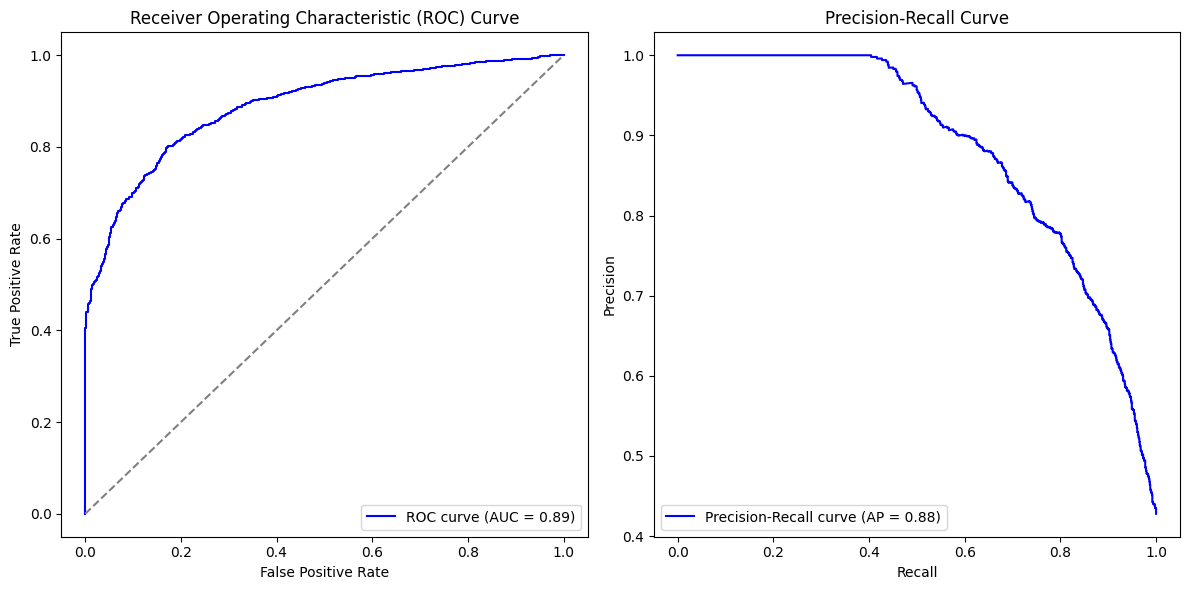

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


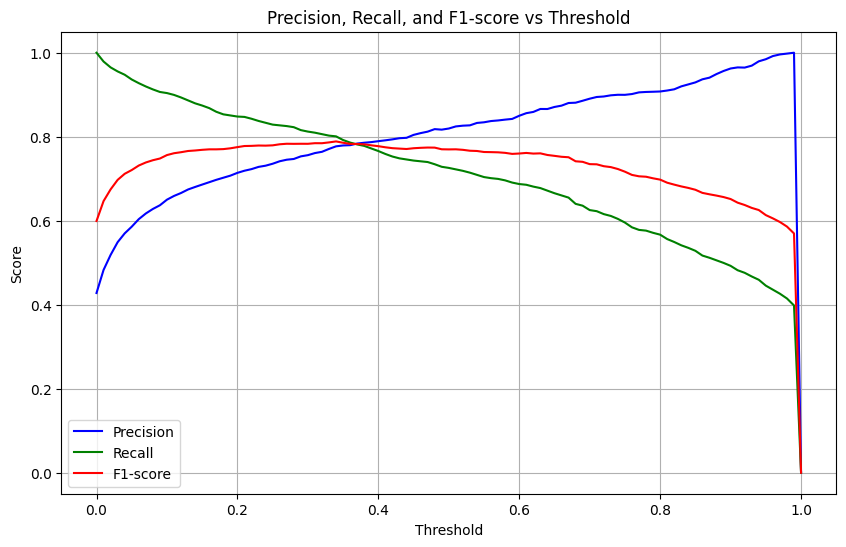

In [261]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = y_prob

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [270]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Define the neural network model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_rmh.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),  # Dropout layer for regularization
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

print(model.summary())

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    X_train_rmh, y_train,
    epochs=25,
    batch_size=16,
    validation_data=(X_val_rmh, y_val),
    class_weight=class_weight_dict,  # ✅ Apply class weights here
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_rmh, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6864 - loss: 0.5973 - val_accuracy: 0.7631 - val_loss: 0.4988
Epoch 2/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7536 - loss: 0.5199 - val_accuracy: 0.7541 - val_loss: 0.4938
Epoch 3/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7635 - loss: 0.4779 - val_accuracy: 0.7919 - val_loss: 0.4386
Epoch 4/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7704 - loss: 0.4756 - val_accuracy: 0.7874 - val_loss: 0.4425
Epoch 5/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7716 - loss: 0.4651 - val_accuracy: 0.7874 - val_loss: 0.4464
Epoch 6/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7808 - loss: 0.4539 - val_accuracy: 0.7724 - val_loss: 0.4575
Epoch 7/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7767 - loss: 0.4626 - val_accuracy: 0.8075 - val_loss: 0.4194
Epoch 8/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7847 - loss: 0.4472 - val_accurac

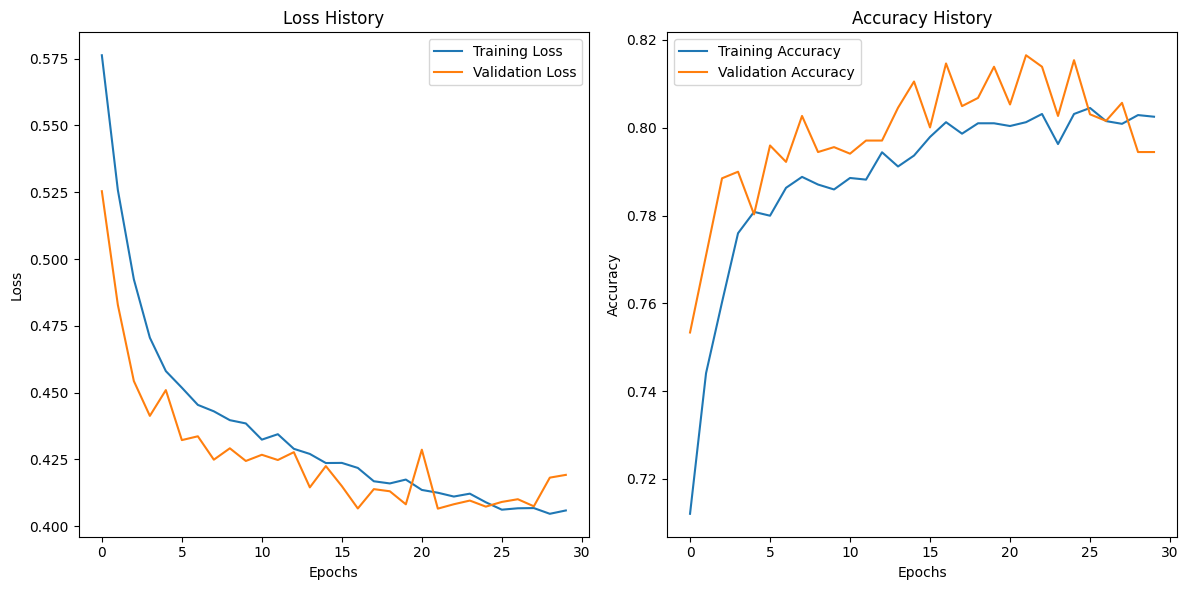

In [203]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


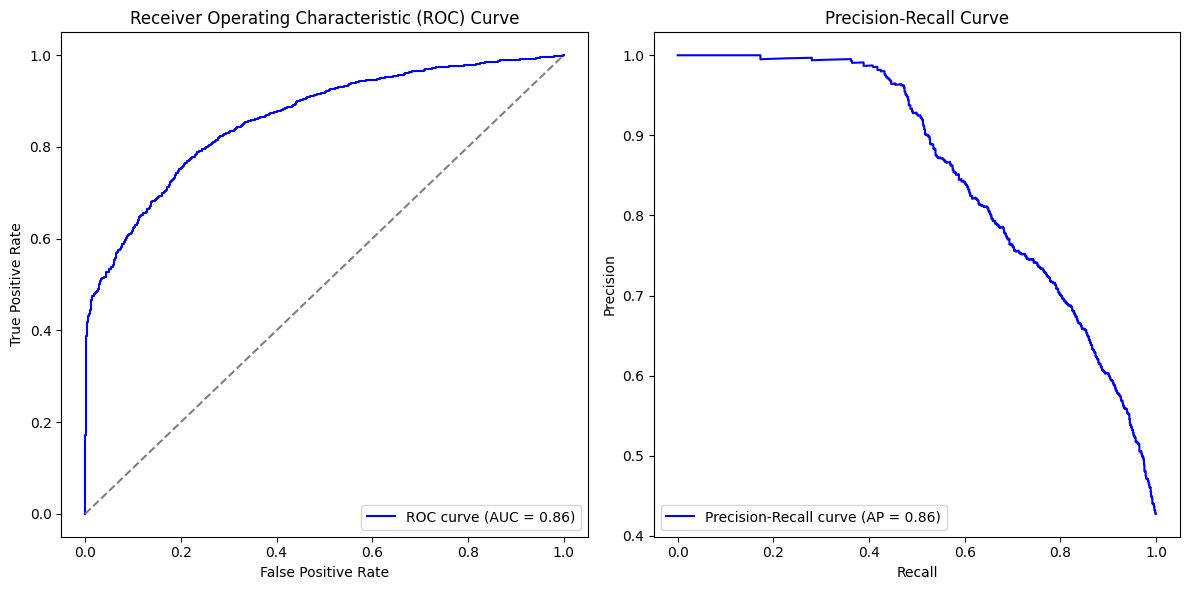

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


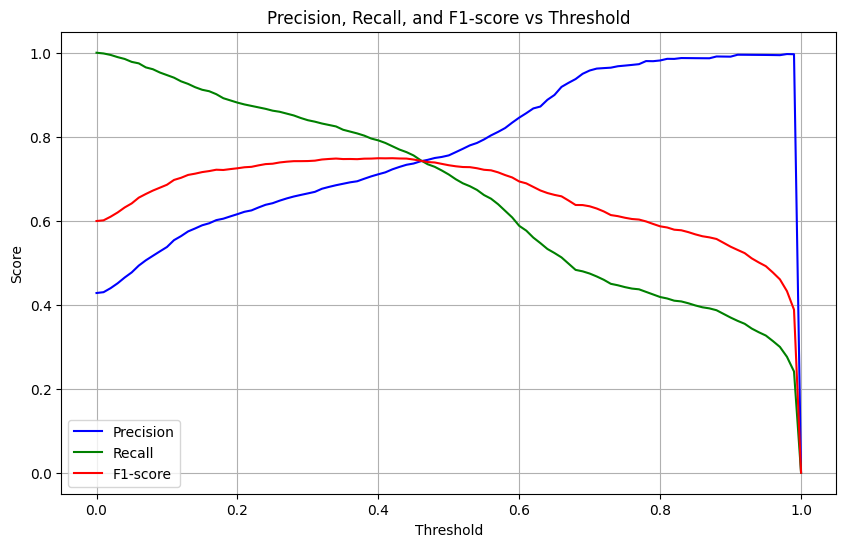

In [271]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_rmh)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [216]:



# Define the neural network model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_smooth.data_matrix.shape[1],)),
    layers.Dropout(0.1),  # Dropout layer for regularization
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

print(model.summary())

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_smooth.data_matrix, y_train, epochs=25, batch_size=16, validation_data=(X_val_smooth.data_matrix, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_smooth.data_matrix, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6745 - loss: 0.6029 - val_accuracy: 0.7541 - val_loss: 0.5368
Epoch 2/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7315 - loss: 0.5509 - val_accuracy: 0.7593 - val_loss: 0.5097
Epoch 3/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7302 - loss: 0.5374 - val_accuracy: 0.7642 - val_loss: 0.4949
Epoch 4/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7526 - loss: 0.5174 - val_accuracy: 0.7661 - val_loss: 0.4819
Epoch 5/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7618 - loss: 0.5033 - val_accuracy: 0.7821 - val_loss: 0.4703
Epoch 6/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7632 - loss: 0.4968 - val_accuracy: 0.7836 - val_loss: 0.4723
Epoch 7/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7648 - loss: 0.4894 - val_accuracy: 0.7735 - val_loss: 0.4676
Epoch 8/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7706 - loss: 0.4748 - val_accurac

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


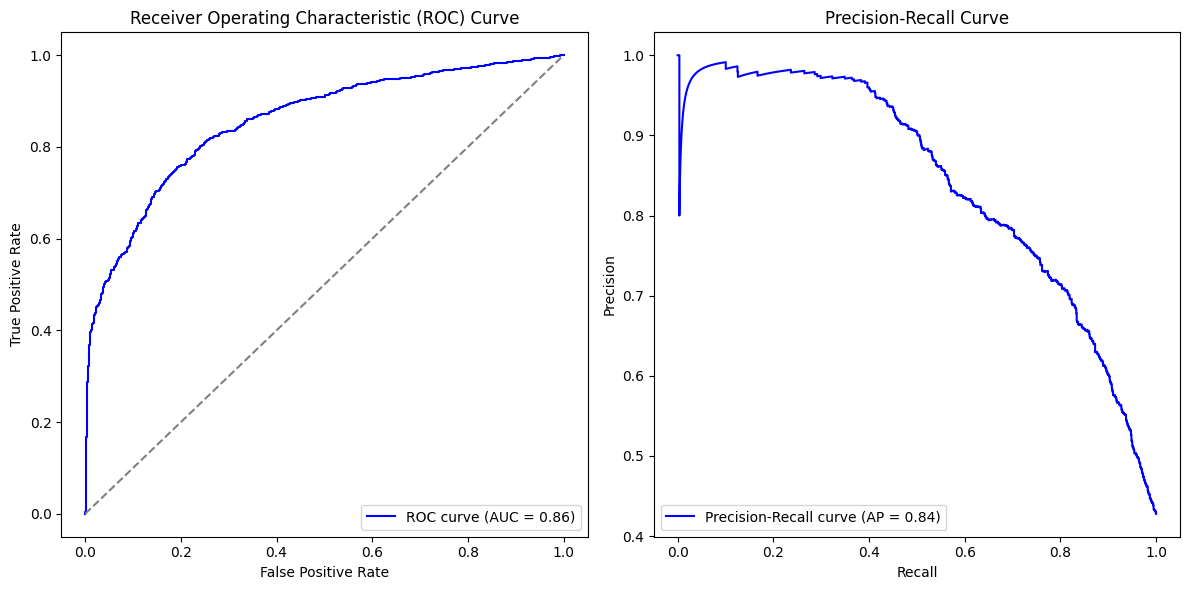

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


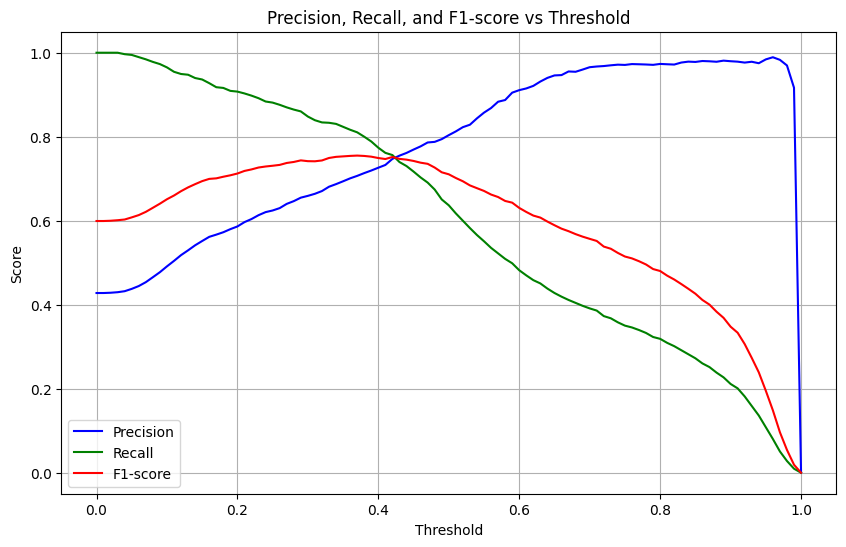

In [217]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_smooth.data_matrix)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [139]:
selected_indices = rmh.get_support(indices=True)
rejected_indices = np.setdiff1d(np.arange(X_train_smooth.data_matrix.shape[1]), selected_indices)

In [208]:
# Replace values at the selected points with 42 in all smoothed datasets
X_train_rmh = skfda.FDataGrid(X_train_smooth.data_matrix.copy(), grid_points=X_train_smooth.grid_points)
X_val_rmh = skfda.FDataGrid(X_val_smooth.data_matrix.copy(), grid_points=X_val_smooth.grid_points)
X_test_rmh = skfda.FDataGrid(X_test_smooth.data_matrix.copy(), grid_points=X_test_smooth.grid_points)
for dataset in [X_train_rmh, X_val_rmh, X_test_rmh]:
    dataset.data_matrix[..., rejected_indices, :] = 42

In [209]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Supón que ya tienes dos listas:
#   evals: lista de listas de floats con las evaluaciones por movimiento
#   cheating: lista de ceros y unos indicadoras de si blancas hicieron trampa

# Parámetros
max_len = 150  # longitud máxima de secuencia
batch_size = 64
epochs = 15


# Definir el modelo
model = Sequential([
    Masking(mask_value=42, input_shape=(max_len, 1)),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

# Compilar
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Ver resumen
model.summary()

# Entrenar con conjunto de validación
history = model.fit(
    X_train_rmh.data_matrix, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_rmh.data_matrix, y_val)
)

# Evaluar en Test
test_loss, test_acc = model.evaluate(X_test_rmh.data_matrix, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Guardar modelo si lo deseas
# model.save('lstm_cheating_detector.h5')


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6186 - loss: 0.6810 - val_accuracy: 0.6977 - val_loss: 0.6213
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6846 - loss: 0.6139 - val_accuracy: 0.7018 - val_loss: 0.5888
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6811 - loss: 0.6069 - val_accuracy: 0.7007 - val_loss: 0.5858
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.6898 - loss: 0.5950 - val_accuracy: 0.7003 - val_loss: 0.5844
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.6754 - loss: 0.5990 - val_accuracy: 0.7033 - val_loss: 0.5818
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.6863 - loss: 0.6002 - val_accuracy: 0.7025 - val_loss: 0.5787
Epoch 7/15
 80/126 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6957 - loss: 0.5821

KeyboardInterrupt: 

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


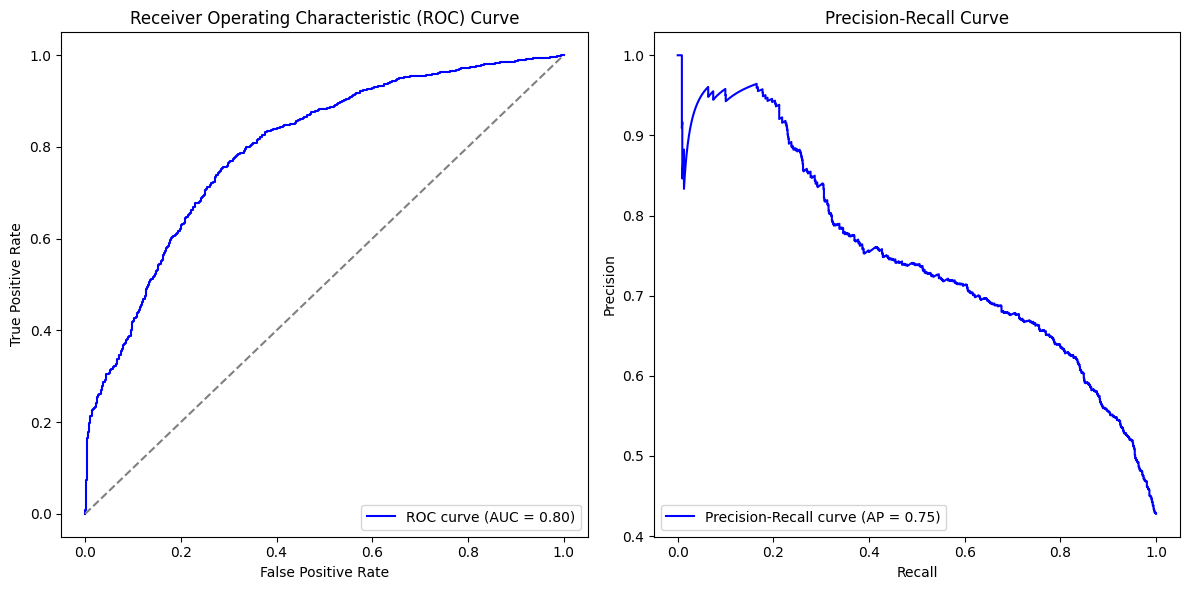

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

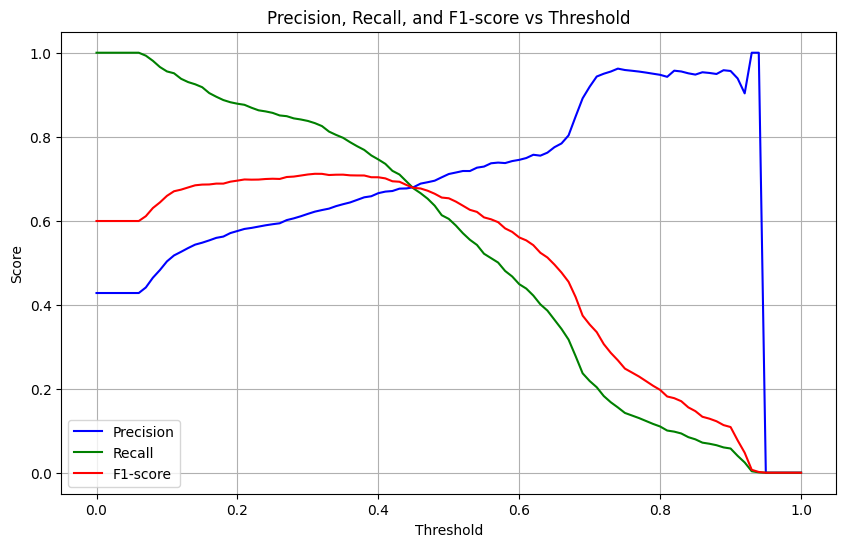

In [170]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_rmh.data_matrix)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


To do: 

1- Hacer mejor descripcion (identificacion de outliers, buscar outliers por clase y tal)
2- Seleccionar modelos para comparación -> comparación de modelos mediante métricas